In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

C:\Users\user\AppData\Roaming\Python\Python36\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] 지정된 프로시저를 찾을 수 없습니다
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# CPU 혹은 GPU 장치 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST('./data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

26422272it [00:07, 3339677.94it/s]                              


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



29696it [00:00, 105907.73it/s]                          


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



4422656it [00:03, 1416127.76it/s]                             


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



6144it [00:00, ?it/s]                   

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

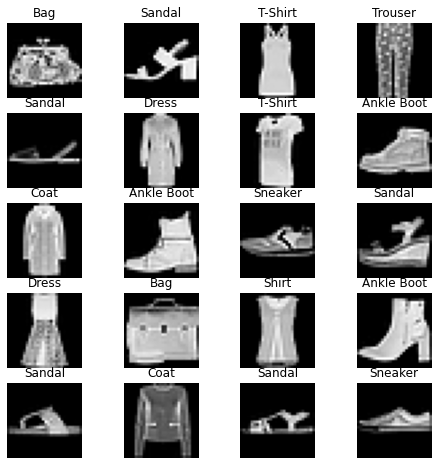

In [5]:
labels_map = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}
fig = plt.figure(figsize=(8,8))
columns=4
rows=5
for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img=train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [6]:
class FashionDNN(nn.Module):
    def __init__(self): # 객체가 생성될 때 자동으로 호출.
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784) # 텐서의 크기 변경 (?, 784)의 크기로 변경하라는 뜻 
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]
predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count +=1

        if not (count%50):
            total=0
            correct=0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions==labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not(count%500):
            print('Iteration:{}, Loss:{}, Accuracy:{}%'.format(count, loss.data, accuracy))


Iteration:500, Loss:0.5968839526176453, Accuracy:83.43000030517578%
Iteration:1000, Loss:0.4561972916126251, Accuracy:84.13999938964844%
Iteration:1500, Loss:0.4038896858692169, Accuracy:83.94999694824219%
Iteration:2000, Loss:0.3832864761352539, Accuracy:85.02999877929688%
Iteration:2500, Loss:0.29820865392684937, Accuracy:86.19999694824219%
Iteration:3000, Loss:0.2699684798717499, Accuracy:85.88999938964844%


In [16]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [17]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [18]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]
predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1

        if not(count%50):
            total=0
            correct=0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28,28))
                outputs = model(test)
                predictions=torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions==labels).sum()
                total += len(labels)

            accuracy = correct *100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not(count%500):
            print('Iteration:{}, loss:{}, Accuracy:{}%'.format(count, loss.data, accuracy))


Iteration:500, loss:0.4840933084487915, Accuracy:87.3699951171875%
Iteration:1000, loss:0.34297463297843933, Accuracy:88.5199966430664%
Iteration:1500, loss:0.27395516633987427, Accuracy:89.0999984741211%
Iteration:2000, loss:0.18484866619110107, Accuracy:89.88999938964844%
Iteration:2500, loss:0.1192372590303421, Accuracy:89.56999969482422%
Iteration:3000, loss:0.19132176041603088, Accuracy:90.45999908447266%
